In [43]:
%load_ext autoreload
%autoreload 2

import numpy as np
import cv2
from time import time, sleep

from utils import *
from custom_pca import custom_pca
from video_loader import VideoLoader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Example of video transformation

In [ ]:
model = custom_pca()

video = VideoLoader('data/sample20s.mp4', grayscale=True)
t1 = time()
frames_rand = video.get_random_frames(0.6)
model.fit(frames_rand)
t2 = time()
reconstructed = []
for j, frames in enumerate(video):
    reconstructed.append(model.inverse_transform(model.transform(frames), shape=(video.height, video.width)))
reconstructed = np.vstack(reconstructed)
t3 = time()
print(reconstruction_error(video.get_all_frames(), reconstructed))
t4 = time()

print('Fitting time:', t2-t1)
print('Transform:', t3-t2)
print('Error calculation:', t4-t3)

### LDS framework

Default of linear dynamic system is an ARMA:
$$x_{t+1} = Ax_t + Bv_t $$
$$y_t = \phi(x_t) + w_t$$

We will begin with:
$$x_{t+1} = Ax_t + b $$
$$y_t = \phi(x_t)$$
The $y$'s are the frames, $x$ the low dimensional representation (obtained with pca), $\phi$ the inverse transform of pca

In [44]:
import torch

In [39]:
import torch.nn as nn
import torch.nn.functional as F

ncomp = 20
bs = 64
num_epoch = 1000

In [40]:
model = custom_pca(ncomp=ncomp)

video = VideoLoader('data/sample20s.mp4', grayscale=True)
frames_rand = video.get_random_frames(0.5)
model.fit(frames_rand)

reduced = []
for frames in video:
    reduced.append(model.transform(frames))
xs = np.vstack(reduced)

reconstructed = []
for frame in xs:
    reconstructed.append(model.inverse_transform(frame[np.newaxis,:], 
                                                 shape=(video.height, video.width)))
reconstructed = np.vstack(reconstructed)

In [41]:
def criterion(output, gt):
    return torch.sqrt(torch.mean((output[:-1] - gt[1:])**2))

In [48]:
#xs = torch.from_numpy(xs)
xs = xs.float()
lds = nn.Linear(ncomp, ncomp)
optimizer = torch.optim.SGD(lds.parameters(), 0.0001)
for i in range(num_epoch):
    for batch in xs.split(bs):
        output = lds(batch)
        loss = criterion(output, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if i % 50 == 0:
        with torch.no_grad():
            print(criterion(lds(xs), xs).item())

208.63363647460938
60.943721771240234
49.458595275878906
43.88878631591797
40.41770553588867
38.29336166381836
36.8950309753418
35.93551254272461
35.24397659301758
34.72303771972656
34.31101989746094
33.97127914428711
33.681922912597656
33.429508209228516
33.205528259277344
33.00435256958008
32.82210922241211
32.656028747558594
32.50400161743164
32.36442184448242


In [49]:
xt = xs[0]
generated = [xt.numpy()]
for i in range(len(xs)-1):
    xt = lds(xt)
    generated.append(xt.detach().numpy())

ys = []
for xt in generated:
    ys.append(model.inverse_transform(xt).reshape(video.height, video.width))
ys = np.array(ys)

In [50]:
show_video(ys)

In [79]:
print("Error of reconstruction:")
print("Without prediction:", reconstruction_error(video.get_all_frames(), reconstructed))
print("With prediction:", reconstruction_error(video.get_all_frames(), ys))

Error of reconstruction:
Without prediction: 2.3006290616128737
With prediction: 8.962386536253646


### Error comparison for big sample

In [28]:
video = VideoLoader('data/big_sample.mp4', grayscale=True, scale=(256,256))

for ncomp in [10,25,50,100,150]:
    t1 = time()
    pca_model = custom_pca(ncomp)
    pca_model.fit(video.get_random_frames(0.2))
    
    t2 = time()
    reconstructed = []
    for frames in video:
        reconstructed.append(pca_model.inverse_transform(pca_model.transform(frames), 
                                                         shape=(video.height, video.width)))
    reconstructed = np.vstack(reconstructed)
    t3 = time()
    #write_video(f'data/big_sample_{ncomp}.mp4', reconstructed, video.width, video.height, video.fps, grayscale=True)
    print(f"Error for {ncomp} components:", reconstruction_error(video.get_all_frames(), reconstructed))
    t4 = time()
    print(f"Time (sec):", int(t2-t1), int(t3-t2), int(t4-t3))

Error for 10 components: 8.629953490550415
Time (sec): 44 87 78
Error for 25 components: 8.126146335849874
Time (sec): 44 80 74
Error for 50 components: 7.621554334321371
Time (sec): 47 86 73
Error for 100 components: 6.846177024734586
Time (sec): 51 89 75
Error for 150 components: 6.33030285308229
Time (sec): 59 93 82


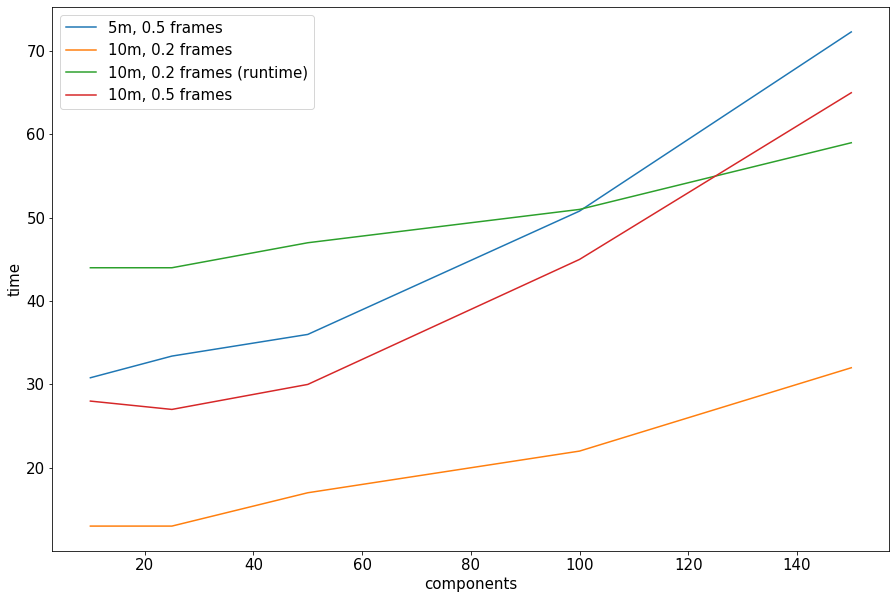

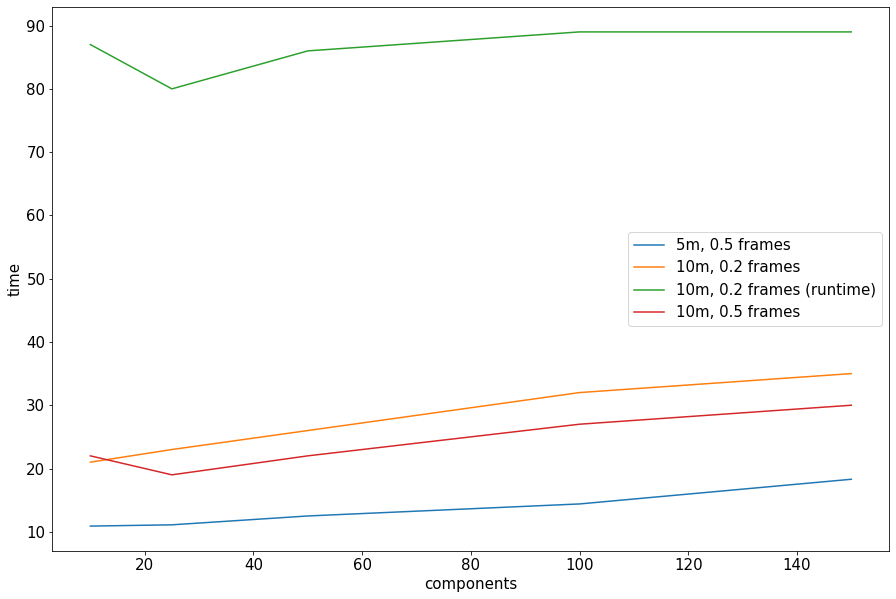

<Figure size 1080x720 with 0 Axes>

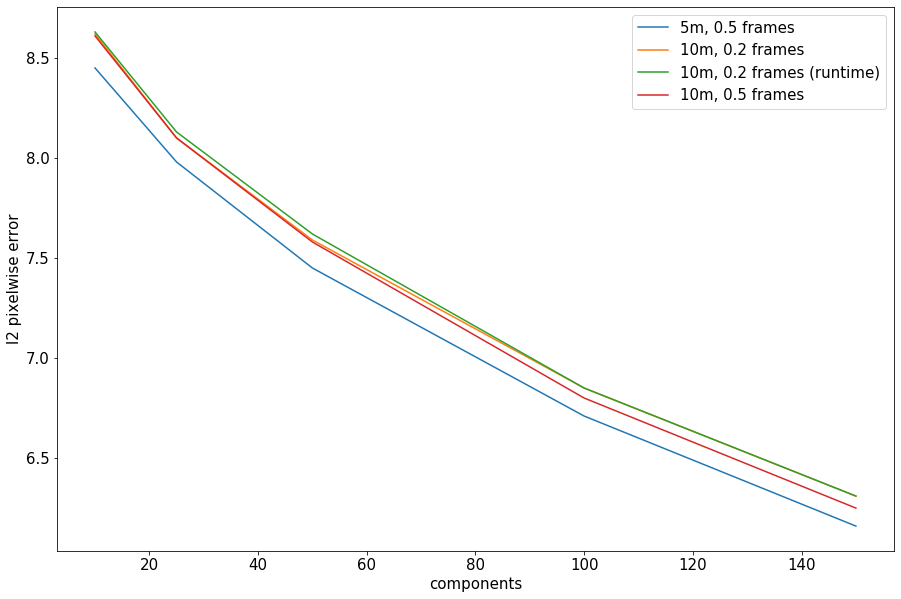

In [37]:
from matplotlib import pyplot as plt
components = [10,25,50,100,150]
fitting_times = np.array([[30.8,33.4,36,50.8,72.3],
                         [13,13,17,22,32],
                         [44,44,47,51,59],
                         [28,27,30,45,65]])
labels=['5m, 0.5 frames','10m, 0.2 frames','10m, 0.2 frames (runtime)','10m, 0.5 frames']
transform_times = np.array([[10.9,11.1,12.5,14.4,18.3],
                           [21,23,26,32,35],
                           [87,80,86,89,89],
                           [22,19,22,27,30]])
errors = np.array([[8.45, 7.98,7.45,6.71,6.16],
                  [8.62,8.1,7.59,6.85,6.31],
                  [8.63,8.13,7.62,6.85,6.31],
                  [8.61,8.1,7.58,6.8,6.25]])

plt.rcParams.update({'font.size': 15})

plt.figure(figsize=(15,10))
plt.xlabel('components')
plt.ylabel('time')
for y, label in zip(fitting_times, labels):
    plt.plot(components, y, label=label)

plt.legend()
plt.show()

plt.figure(figsize=(15,10))
plt.xlabel('components')
plt.ylabel('time')
for y, label in zip(transform_times, labels):
    plt.plot(components, y, label=label)

plt.legend()
plt.show()

plt.figure(figsize=(15,10))
plt.figure(figsize=(15,10))
plt.xlabel('components')
plt.ylabel('l2 pixelwise error')
for y, label in zip(errors, labels):
    plt.plot(components, y, label=label)

plt.legend()
plt.show()

### Experimental setup video

In [38]:
video = VideoLoader('data/experience/TicDetectorCam_Front.mp4', grayscale=True, scale=(512,512))

ncomp = 100
pca_model = custom_pca(ncomp)
pca_model.fit(video.get_random_frames(0.5))

reconstructed = []
for frames in video:
    reconstructed.append(pca_model.inverse_transform(pca_model.transform(frames), 
                                                     shape=(video.height, video.width)))
reconstructed = np.vstack(reconstructed)
write_video(f'data/experience/TicDetectorCam_Front_100.mp4', reconstructed, video.width, video.height, video.fps, grayscale=True)
print(f"Error for {ncomp} components:", reconstruction_error(video.get_all_frames(), reconstructed))


Error for 100 components: 4.235443171642321


In [ ]:
write_video(f'data/experience/TicDetectorCam_Front_transform.mp4')